# 1.테슬라 주가 분석하기

이번엔 테슬라 주가에 대한 분석을 해보려고 한다. 주가처럼 연속적인 시간에 따라 다르게 측정되는 데이터를 시계열 데이터라 하며, 이를 분석하는 것을 '시계열 데이터 분석' 이라고 한다. 

### step.1 탐색: 날짜 정보가 포함된 데이터 살펴보기

데이터 출처 : 야후 파이낸스 (https://finance.yahoo.com/), 이것이 데이터 분석이다.(3-2 비트코인 시세분석 참조)


In [151]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

분석에 필요한 라이브러리를 불러온다. 주가 분석을 위한 데이터는 주가 변동이 컸었던 2019-01-1부터 2021-03-31까지만 불러왔다.

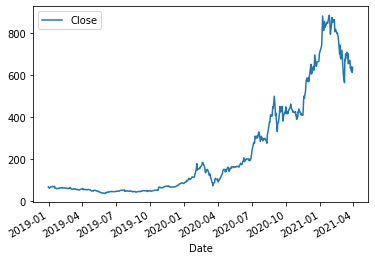

In [152]:
tsla_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2021-03-31', 
                      progress=False)
tsla_df

tsla_df= tsla_df[["Close"]]


tsla_df.plot()
plt.show()

In [153]:
tsla_df['Date'] = tsla_df.index

/home/jaeyoon89/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [154]:
print(tsla_df.shape)
print(tsla_df.info())
tsla_df.tail()

(566, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 566 entries, 2018-12-31 to 2021-03-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Close   566 non-null    float64       
 1   Date    566 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.3 KB
None


,Close,Date
Date,,
2021-03-24,630.270020,2021-03-24
2021-03-25,640.390015,2021-03-25
2021-03-26,618.710022,2021-03-26
2021-03-29,611.289978,2021-03-29
2021-03-30,635.619995,2021-03-30


우선 테슬라 주가 데이터를 탐색하자. 위 결과와 같이 Open,High,Low,Close, Adj Close 총 5개의 피처로 구성되어 있다.

데이터를 확인해 보면 총 5개의 컬럼으로 구성되어 있는데 이번시간에는 High 즉 하루 중 주가가 가장 높았었던 데이터로 예측 분석을 해보려고 한다.

### step.2 예측: 파이썬 라이브러리를 활용해 시세 예측하기



이번 절에서 첫 번째로 사용할 시계열 예측 분석 방법은 ARIMA 분석 방법이다. ARIMA는 전통적인 시계열 예측 방법으로 크게 두 가지 개념을 포함하고 있다. 첫 번째는 AR모델로 자기 자신의 과거를 정보로 사용하는 것이다. 두 번째 개념은 MA모델로 '이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다' 라는 방법이다. 그리고 이 둘을 합친 것을 ARMA 모델이라고 하며, 조금 더 나아간 ARIMA 모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법이다.

In [123]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(tsla_df.Close.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

/home/jaeyoon89/.local/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


LinAlgError: SVD did not converge

다음으로 High값의 ARIMA 모델의 학습 결과를 알아보자. 아래의 실행 결과 중 첫 번째 그래프는 학습한 모델에 학습 데이터셋을 넣었을 때의 시계열 예측 결과이다.

- ARIMA 모델 활용하기 : 실제 데이터와의 비교

<AxesSubplot:>

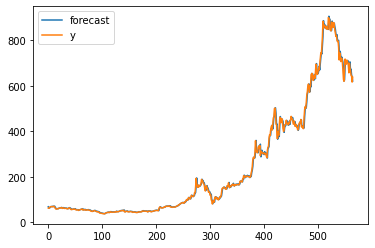

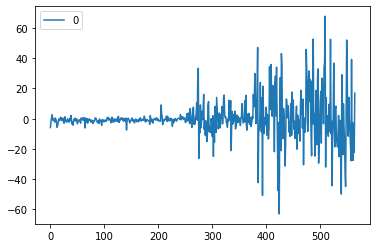

In [124]:
fig = model_fit.plot_predict() 
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()

두 번째 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프이다. 만약 이 그래프 폭이 일정하다면 좋은 예측 모델을 학습시킨 것이라고 생각할 수 있다. 하지만 실행 결과에서는 오차 변동이 매우 불안정하다. 다음으로 ARIMA 모델을 평가해보자. 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용하자.

In [142]:
forecast_data = model_fit.forecast(steps=5)

tsla_test_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2021-03-31', 
                      progress=False)

pred_y = forecast_data[0].tolist()
test_y = tsla_test_df.y.values

pred_y_lower = []
pred_y_upper = []
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

AttributeError: 'DataFrame' object has no attribute 'y'

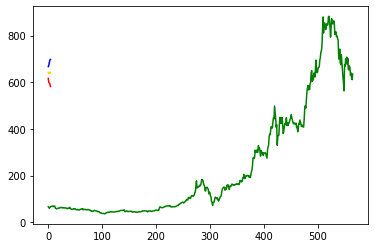

In [126]:
plt.plot(pred_y, color="gold")
plt.plot(pred_y_lower, color="red")
plt.plot(pred_y_upper, color="blue")
plt.plot(test_y, color="green")